## An agent with three custom tools:
 1. Weather tool: Returns simulated weather for a given city
 2. Dictionary tool: Looks up word definitions (simulate with a small dict)
 3. Web search tool: Uses DuckDuckGo to search the web for information


#### Importing require libraries

In [145]:
import os
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage, SystemMessage
from langchain_core.tools import tool
from typing import Literal
from langchain_openai import ChatOpenAI
import requests
from ddgs import DDGS

#### Initializing the llm

In [146]:
# Load api key and intialize llm
load_dotenv()
llm= ChatOpenAI(model='gpt-4o-mini', temperature=0)

#### Preparing the system messages

In [147]:
# define the system prompt
sys_msg=SystemMessage(content="""
You are a helpful assistant with access to tools.
Only use the avalable tools when necessary- for simple questions, answer directly
""")

#### Building nodes/tools

##### Building the weather tool

In [148]:
@tool
def check_weather(city:str) -> str:
    """
    check the weather of a given city and return the weather details
    
    Args: city
    Return: weather details

    """
    url = "https://api.openweathermap.org/data/2.5/weather"
    params={
        "q":city,
        "appid": os.getenv("WEATHER_KEY"),
        "units": "metric"
    }
    response= requests.get(url, params=params)
    if response.status_code!=200:
        return f'Failed to get weather for {city}. Reason:{response.text}'
    data= response.json()
    weather= data["weather"][0]["description"]
    temp=data["main"]["temp"]
    humidity= data["main"]["humidity"]
    return(
        f"Current weather in {city}:\n"
        f"Weather Condition: {weather}"
        f"Temperature: {temp}°C"
        f"Humidity: {humidity}%"
    )
print(f"✅ Weather tool is ready!")

✅ Weather tool is ready!


##### Building the dictionary tool

In [149]:
@tool
def check_dictionary(word:str)-> str:
    """
    Looks up word definitions and return it

    Agrs: word to look up for
    return: The word and it meaning
    """
    dictionary = {
        "algorithm": "A step-by-step procedure for solving a problem or performing a computation.",
        "api": "A set of rules that allows different software applications to communicate with each other.",
        "bug": "An error or flaw in software that causes incorrect or unexpected results.",
        "cache": "A temporary storage area used to speed up data access.",
        "compiler": "A program that translates source code into executable machine code.",
        "database": "An organized collection of structured information or data.",
        "debugging": "The process of identifying and fixing errors in software.",
        "framework": "A reusable software platform that provides a foundation for building applications.",
        "function": "A reusable block of code that performs a specific task.",
        "git": "A distributed version control system used to track changes in source code.",
        "interface": "A point of interaction between components, systems, or users.",
        "library": "A collection of pre-written code that developers can reuse.",
        "loop": "A programming construct that repeats a set of instructions until a condition is met.",
        "object": "An instance of a class containing data and behavior.",
        "parameter": "A variable used to pass information into a function or method.",
        "runtime": "The period during which a program is executing.",
        "syntax": "The set of rules that defines the structure of a programming language.",
        "thread": "A lightweight unit of execution within a process.",
        "variable": "A named storage location used to hold data.",
        "version": "A specific release or iteration of a software product."
    }
    word_lower= word.lower()
    if word_lower in dictionary:
        return f"{word}: {dictionary[word_lower]}"
    else:
        return f"{word} has no definition in my dictionary"

print(f"✅ Mini dictionary tool is ready!")

✅ Mini dictionary tool is ready!


##### Building the Web search tool

In [150]:
@tool
def web_search(query: str, max_result:int =5)->str:
    """
    Search web for information on a given query

    Agrs: 
        query: search query
        max_result= maximum number of result to return

    Return:
        A summary of search results (title + snippet + link)
    """
    results_text=[]

    with DDGS() as dggs:
        results= dggs.text(query, max_results=max_result)

        for i, r in enumerate(results,start=1):
            title=r.get("title", "No title")
            snippet= r.get("body", "No description")
            link= r.get("href", "No link")

            results_text.append(
                f"{i}.{title}\n"
                f"  {snippet}\n"
                f"  Source:{link}"
            )
    if not results_text:
        return "No result found"
    else:
        return "\n\n".join(results_text)

print(f"✅ Web search tool is ready!")


✅ Web search tool is ready!


#### Preparing the tools and bind with llm

In [151]:
# Preparing the tools and bind with llm
tools= [check_weather,check_dictionary,web_search]
llm_with_tools=llm.bind_tools(tools)

#### Building the nodes

In [152]:
from typing import Literal

# Assistant node
def assistant(state: MessagesState) -> dict:
    """Assistant node - decides to use tool or answer directly"""
    messages = [sys_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Route node
def should_use_tool(state: MessagesState) -> Literal["tools", "__end__"]:
    """Route to tools if the last AI message contains tool calls."""
    last_message = state["messages"][-1]
    tool_calls = getattr(last_message, "tool_calls", None) or []
    return "tools" if tool_calls else "__end__"


#### Building the graph

In [153]:
def build_graph()->StateGraph:
    builder= StateGraph(MessagesState)
    # Add nodes
    builder.add_node("assistant", assistant)
    builder.add_node("tools", ToolNode(tools))

    # create edges
    builder.add_edge(START,"assistant") 
    builder.add_conditional_edges("assistant", should_use_tool, {"tools":"tools", "__end__":END})
    builder.add_edge("tools", "assistant")

    # compile the agent with memory
    memory=MemorySaver()
    agent=builder.compile(memory)
    return agent

# ===========================================================================
agent= build_graph()

#### Helper functions

In [154]:
# Diplay the graph flowchart
def display_Graph(agent:StateGraph=agent):
    """Display the graph flowchart diagram"""
    try:
        return display(Image(agent.get_graph().draw_mermaid_png()))
    except Exception as e:
        return (f"Error displaying the graph. Reason: {str(e)}")

def run_agent():
    """
    Run an interactive chat session.
    Type 'exit' or 'quit' to stop.
    """
    print("\n" + "="*70)
    print("🤖 Welcome to Olasquare assistant Agent interactive chat session")
    print("Type your message and press Enter. Type 'exit' to quit.")
    print("="*70 + "\n")
    
    thread_id = "user1"
    prev_len= 0
    while True:
        user_input = input("\n👤 You:  ").strip()
        
        if user_input.lower() in ["exit", "quit"]:
            print("\n👋 Goodbye!\n")
            break
        
        if not user_input:
            continue
        
        # Get response
        result = agent.invoke(
            {"messages": [HumanMessage(content=user_input)]},
            config={"configurable": {"thread_id": thread_id}}
        )
        all_msg= result["messages"]
        new_msg = all_msg[prev_len:]
        prev_len=len(all_msg)

         # Print user's input
        print(f"\n👤 User: {str(user_input)}")

        # Last message returned by the agent
        last_msg = result["messages"][-1]
        print(f"🤖 Agent:  {getattr(last_msg, 'content', '')}")

        # Tool calls
        tool_calls = []
        for m in new_msg:
            if isinstance(m, AIMessage) and (getattr(m, "tool_calls", None) or []):
                tool_calls.extend(m.tool_calls)

        if tool_calls:
            print("🔨 Tool called:", ", ".join(tc.get("name", "unknown") for tc in tool_calls))
            print("")

### Main driver code


🤖 Welcome to Olasquare assistant Agent

🤖 === Please choose operation to perform ===
1. Check the agent FlowChart
2. Run an intercative chat
 Type exit or quit to stop the chat
------------------------------------------------------------


👤 User: 1


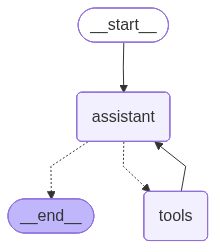


🤖 === Please choose operation to perform ===
1. Check the agent FlowChart
2. Run an intercative chat
 Type exit or quit to stop the chat
------------------------------------------------------------


👤 User: 2

🤖 Welcome to Olasquare assistant Agent interactive chat session
Type your message and press Enter. Type 'exit' to quit.


👤 User: Hi. I am Saheed. What can you do for me?
🤖 Agent:  Hi Saheed! I can assist you with a variety of tasks, including:

1. **Weather Information**: I can provide current weather details for any city.
2. **Word Definitions**: I can look up definitions for words you want to know more about.
3. **Web Searches**: I can search the web for information on specific topics or queries.

Let me know how I can help you today!

👤 User: What's the weather in Lagos?
🤖 Agent:  The current weather in Lagos is as follows:
- **Weather Condition**: Scattered clouds
- **Temperature**: 25.42°C
- **Humidity**: 86%

If you need more information or updates, feel free to ask!
🔨 T

In [155]:
if __name__ == "__main__":
    # runnig the app
    print("\n" + "="*70)
    print("🤖 Welcome to Olasquare assistant Agent")
    while True:
        print("\n🤖 === Please choose operation to perform ===")
        print("1. Check the agent FlowChart")
        print("2. Run an intercative chat")
        print(" Type exit or quit to stop the chat")
        print("--"*30)
        print("")
        choice = input("Your choice here:  ")
        print(f"\n👤 User: {str(choice)}")
        if choice.lower() in ["exit", "quit"]:
            print("\n👋 Goodbye!\n")
            break
        elif choice=="1":
            display_Graph()
        elif choice=="2":
            run_agent()
        else:
            print("❌ Invalid input")